# Example spike-sorting analysis with sample data

This tutorial is also available as a [collab notebook](https://github.com/MouseLand/Kilosort/blob/main/docs/tutorials/kilosort4.ipynb)
if you would like to try Kilosort4 without installing the code locally.

### 1. Download example data

This is an example electrophysiological recording from the International Brain Laboratory, recorded using a Neuropixels 1.0 probe (all data [here](https://ibl.flatironinstitute.org/public/)). The full recording is over 4000 seconds long, and the cropped recording is 90 seconds long.

Downloading the recording may take a few minutes. If it fails, please try running the cell again.

You can alternatively use any .bin file. See the "Loading other data formats" tutorial for loading other file extensions.
When using your own data, be sure to check that you've specified the correct dtype (default is int16) and that the data is in row-major (or 'C') order, the default for NumPy.

In [1]:
import urllib.request
from pathlib import Path
from tqdm import tqdm

# NOTE: Be sure to update this filepath if you want the data downloaded to
#       a specific location.
SAVE_PATH = Path(r'D:\Data\Kilosort\ZFM-02370_mini.imec0.ap.bin')

class DownloadProgressBar(tqdm):
    """ from https://stackoverflow.com/a/53877507 """
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

## CROPPED DATASET
URL = 'http://www.kilosort.org/downloads/ZFM-02370_mini.imec0.ap.bin'
download_url(URL, SAVE_PATH)

ZFM-02370_mini.imec0.ap.bin: 2.08GB [03:26, 10.1MB/s]                               


In [2]:
# Download channel maps for default probes
from kilosort.utils import download_probes
download_probes()

100%|██████████| 2.02k/2.02k [00:00<00:00, 2.07MB/s]
100%|██████████| 2.03k/2.03k [00:00<00:00, 2.05MB/s]
100%|██████████| 2.02k/2.02k [00:00<00:00, 2.05MB/s]
100%|██████████| 2.00k/2.00k [00:00<00:00, 3.87MB/s]
100%|██████████| 555/555 [00:00<?, ?B/s] 


## Run kilosort

In [3]:
from kilosort import run_kilosort

# NOTE: 'n_chan_bin' is a required setting, and should reflect the total number
#       of channels in the binary file. For information on other available
#       settings, see `kilosort.run_kilosort.default_settings`.
settings = {'data_dir': SAVE_PATH.parent, 'n_chan_bin': 385}

ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(
        settings=settings, probe_name='neuropixPhase3B1_kilosortChanMap.mat',
        # save_preprocessed_copy=True
        )

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\Kilosort\ZFM-02370_mini.imec0.ap.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 2700000
kilosort.run_kilosort: N seconds: 90.0
kilo

If you want to save a pre-processed copy of the data (including whitening, high-pass filtering, and drift correction), you can set `save_preprocessed_copy = True` in the arguments for `run_kilosort`. Alternatively, `kilosort.io.save_prepocessing` can be used as a standalone utility to generate the same copy from saved sorting results, but this will not update options for Phy. By default, results are saved in the same directory as the binary data in the `kilosort4` subdirectory.

In [4]:
from kilosort.io import save_preprocessing, load_ops

# NOTE: This will only create the .dat file, it will *NOT* update options for Phy.
#       If you want to use this with Phy, you will need to modify `params.py`
#       in the results directory to point to this new file. Additionally,
#       you must set `hp_filtered=True` and `dtype='int16'`.
ops_path = SAVE_PATH.parent / 'kilosort4' / 'ops.npy'
ops = load_ops(ops_path)
save_preprocessing(SAVE_PATH.parent / 'temp_wh.dat', ops, bfile_path=SAVE_PATH)

kilosort.io :  
kilosort.io : ========================================
kilosort.io : Saving drift-corrected copy of data to: D:\Data\Kilosort\temp_wh.dat...
kilosort.io : Writing batch 0/45...
kilosort.io : ========================================
kilosort.io : Copying finished.
kilosort.io :  


## Plot the results

Note: at this point, you can also load the results in `phy`.


Load outputs

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd

from kilosort.io import load_ops


# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
ops = load_ops(results_dir / 'ops.npy')
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

Plot outputs

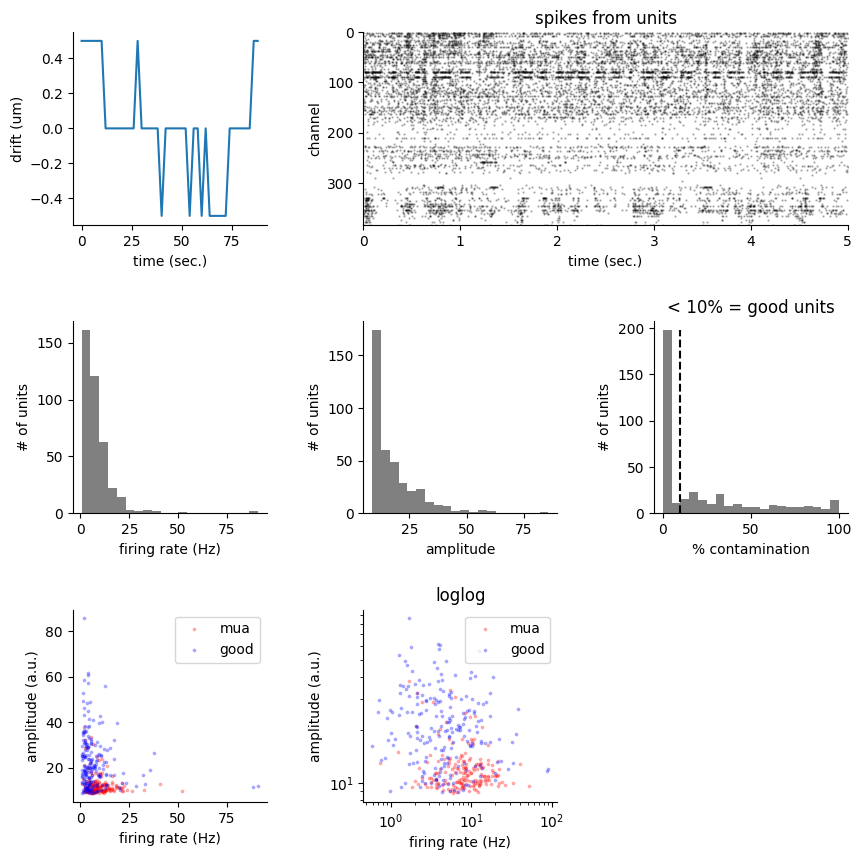

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0 
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


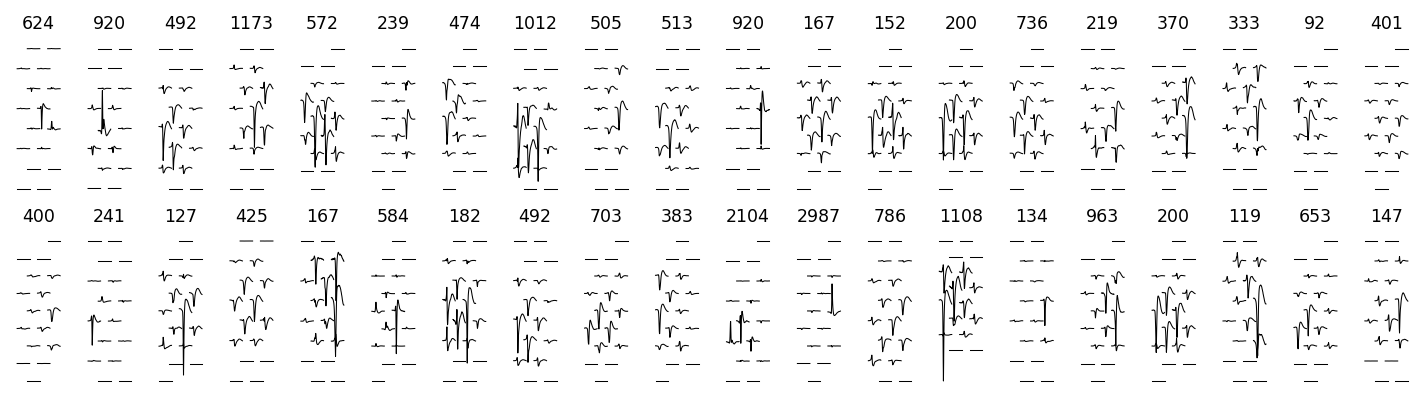

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


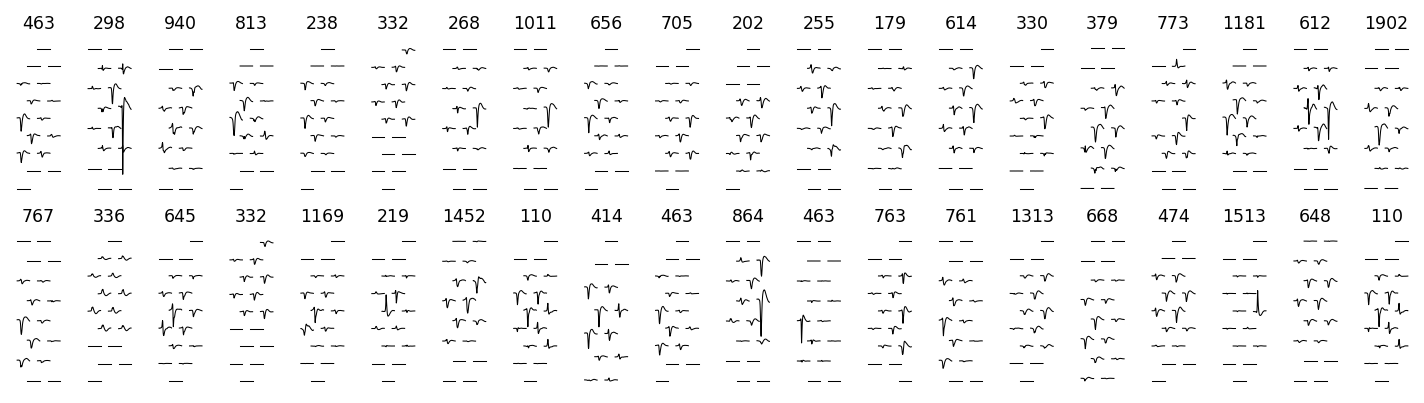

In [8]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units 
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()  
        cb = chan_best[wi]
        nsp = (clu==wi).sum()
        
        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()